## Problem 1.a

In [61]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import requests
import scipy.optimize as opt
from matplotlib import pyplot as plt
%matplotlib notebook

In [7]:
incomes = np.loadtxt('data/incomes.txt')

<IPython.core.display.Javascript object>


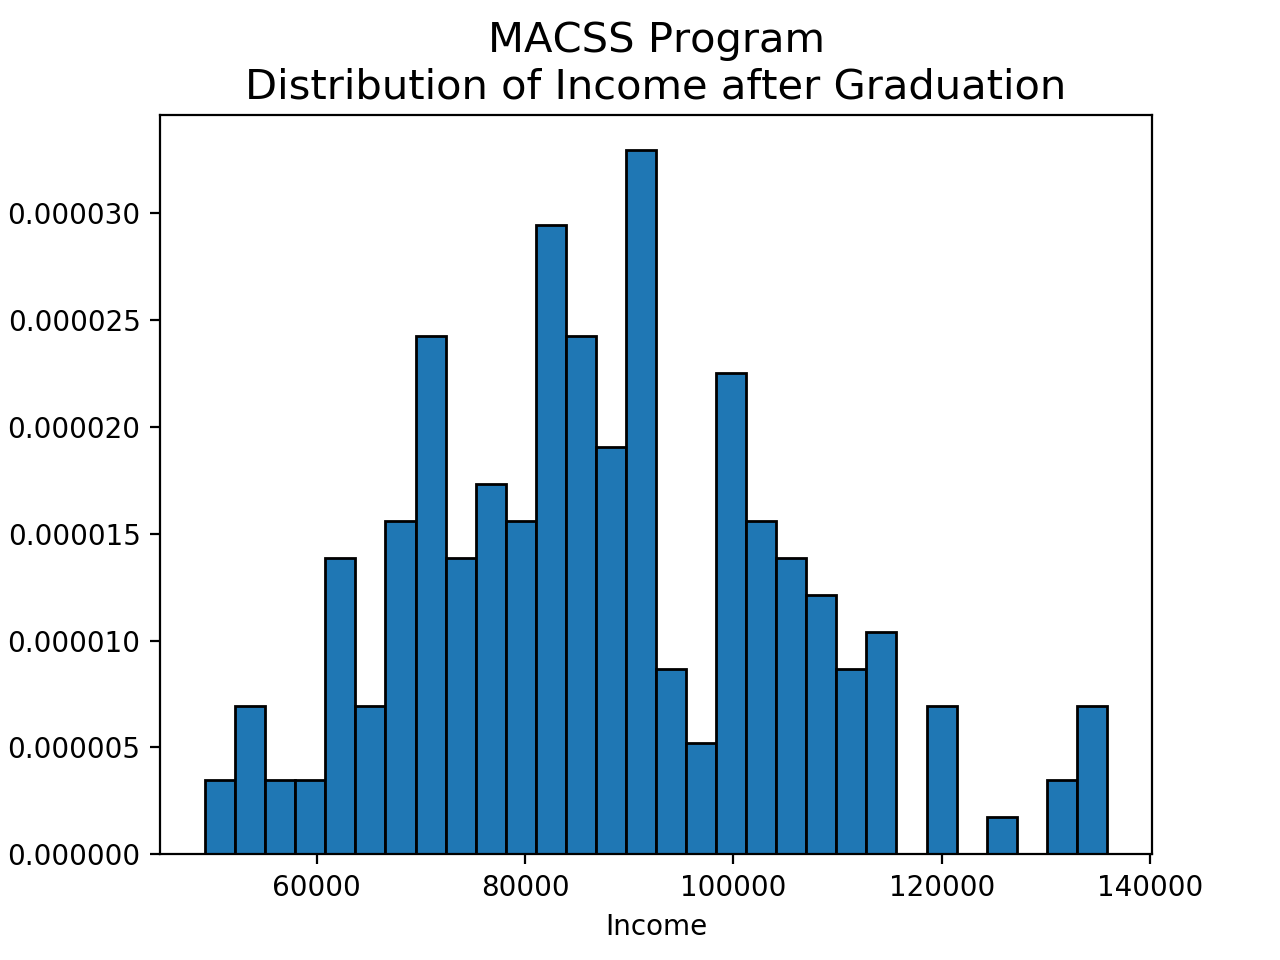

In [8]:
num_bins = 30
plt.hist(incomes, num_bins, density=True, edgecolor='k') # `normed` argument has been deprecated by `matplotlib.pyplot.hist`
plt.title('MACSS Program\nDistribution of Income after Graduation', fontsize=15)
plt.xlabel(r'Income')
plt.ylabel(r'Percent')
plt.show()

## Problem 1.b

In [9]:
def trunc_lognorm_pdf(x_vals, mu, sigma, cut_lb='None', cut_ub='None'):
    
    def lognorm_pdf(x_vals, mu, sigma): 
        return np.array([sts.lognorm(sigma, scale=np.exp(mu)).pdf(point) for point in x_vals])

    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm(sigma, scale=np.exp(mu)).cdf(cut_lb)
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm(sigma, scale=np.exp(mu)).cdf(cut_ub)
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm(sigma, scale=np.exp(mu)).cdf(cut_ub) -
                       sts.lognorm(sigma, scale=np.exp(mu)).cdf(cut_lb))
            
    pdf_vals =  lognorm_pdf(x_vals, mu, sigma) / prob_notcut
    
    return pdf_vals

In [10]:
def log_like_trunc_lognorm(x_vals, mu, sigma, cut_lb='None', cut_ub='None'): 
    pdf_vals = trunc_lognorm_pdf(x_vals, mu, sigma, cut_lb, cut_ub)
    log_pdf_vals = np.log(pdf_vals)
    log_like_val = log_pdf_vals.sum()
    return log_like_val

<IPython.core.display.Javascript object>


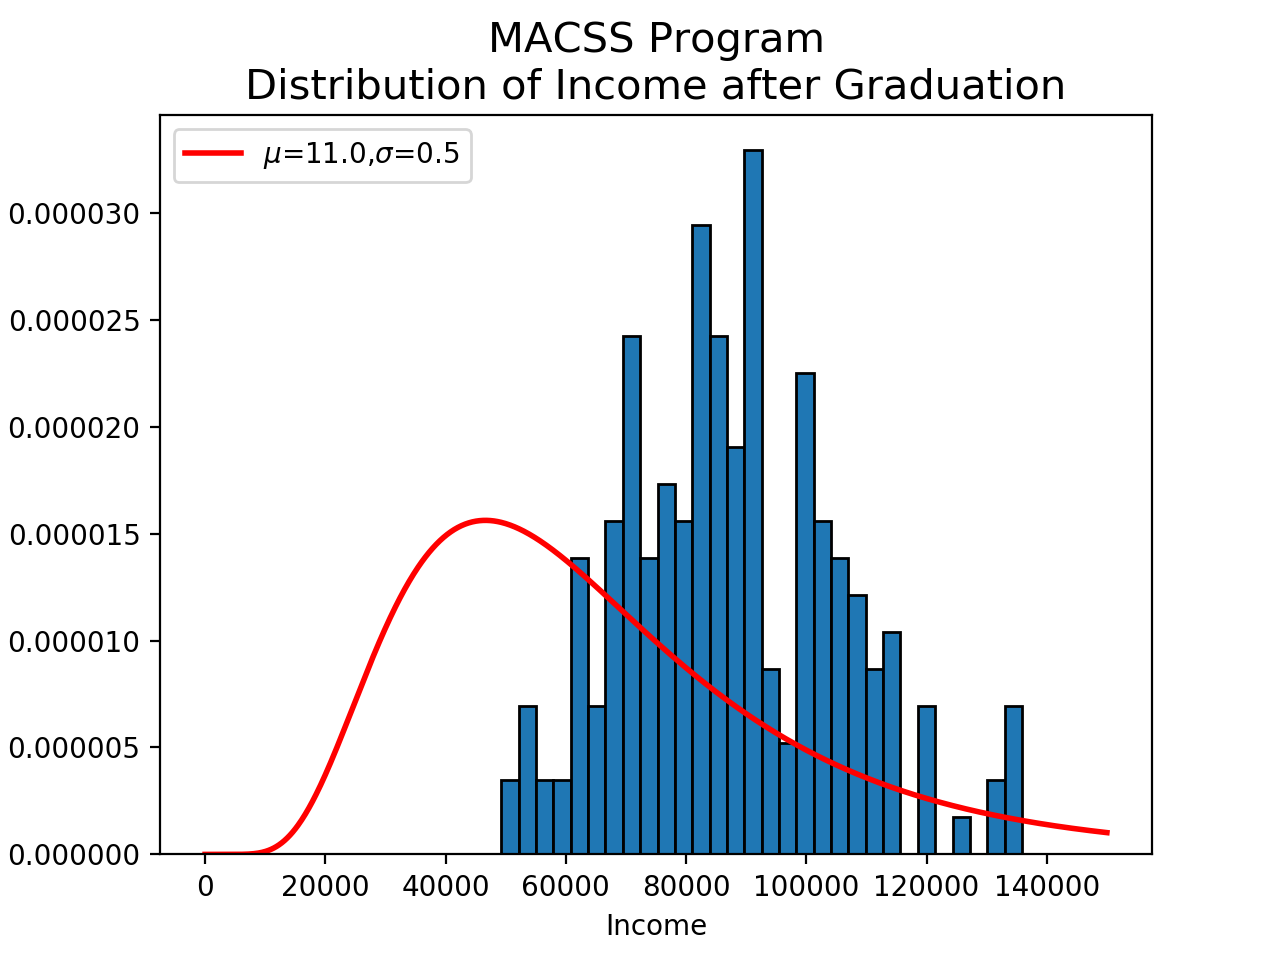

Likelihood value for (mu,sigma)=(11.0, 0.5) and (cut_lb, cut_ub)=(0, 150000): -2379.120591931827


In [12]:
# Plot the histogram of the data
num_bins = 30
plt.hist(incomes, num_bins, density=True, edgecolor='k') # `normed` argument has been deprecated by `matplotlib.pyplot.hist`
plt.title('MACSS Program\nDistribution of Income after Graduation', fontsize=15)
plt.xlabel(r'Income')
plt.ylabel(r'Percent')

# Plot the pdf of truncated LN(11.0, 0.5) for (0, 150000]
cut_lb = 0
cut_ub = 150000
mu = 11.0
sigma = 0.5
dis_pts = np.linspace(cut_lb, cut_ub, 1000)
plt.plot(dis_pts, trunc_lognorm_pdf(dis_pts, mu, sigma, cut_lb, cut_ub),
         linewidth=2, color='r', label=f'$\mu$={mu},$\sigma$={sigma}')
plt.legend(loc='upper left')

print(f'Likelihood value for (mu,sigma)={mu, sigma} and (cut_lb, cut_ub)={cut_lb, cut_ub}: {log_like_trunc_lognorm(incomes, mu, sigma, cut_lb, cut_ub)}')
plt.show()

## Problem 1.c

In [25]:
def crit(parameters, *args): 
    mu, sigma = parameters
    x_vals, cut_lb, cut_ub = args
    log_like_val = log_like_trunc_lognorm(x_vals, mu, abs(sigma), cut_lb, cut_ub)
    return - log_like_val

In [29]:
np.seterr(divide = 'ignore')
mu_init, sigma_init = 11.0, 0.5
params_init = np.array([mu_init, sigma_init])
mle_args = (incomes, cut_lb, cut_ub)
results_uncstr = opt.minimize(crit, params_init, args=mle_args)
# results_cstr = opt.minimize(crit, params_init, args=(mle_args), method='L-BFGS-B',
#                             bounds=((None, None), (1e-1000, None)))
mu_MLE, sig_MLE = results_uncstr.x

print('Estimation of mu: ', mu_MLE)
print('Estimation of sigma: ', sig_MLE)
print('Log Likelihood Value: ', -results_uncstr.fun)
print('VCV = ', results_uncstr.hess_inv)

Estimation of mu:  11.361699968408162
Estimation of sigma:  0.21174326555010628
Likelihood Value:  -2240.934337511636
VCV =  [[0.00028583 0.00029164]
 [0.00029164 0.00036212]]


<IPython.core.display.Javascript object>


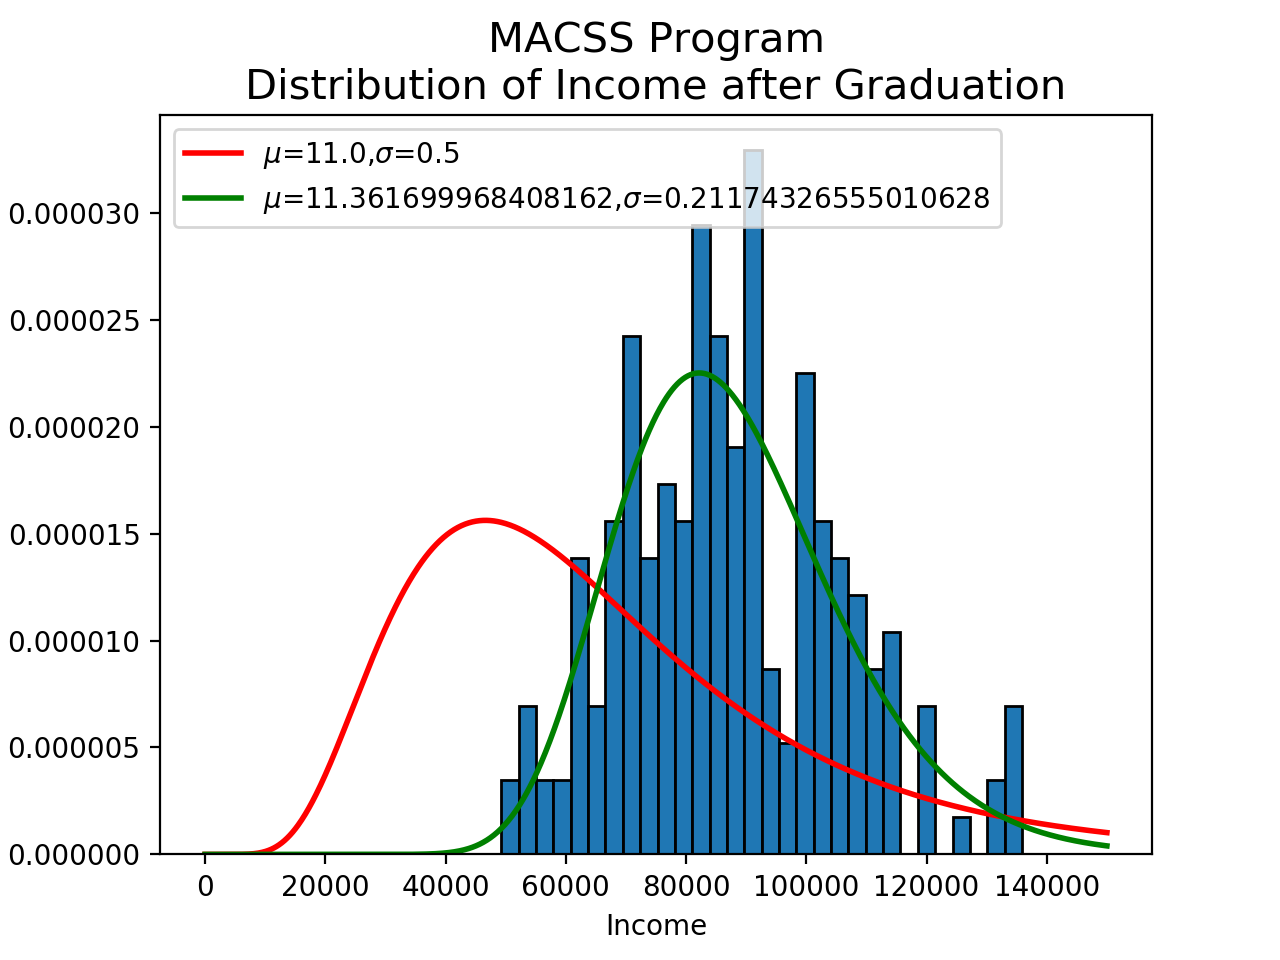

In [33]:
# Plot the histogram of the data
num_bins = 30
plt.hist(incomes, num_bins, density=True, edgecolor='k') # `normed` argument has been deprecated by `matplotlib.pyplot.hist`
plt.title('MACSS Program\nDistribution of Income after Graduation', fontsize=15)
plt.xlabel(r'Income')
plt.ylabel(r'Percent')

# Plot the pdf of LN(11.0, 0.5)
dist_pts = np.linspace(cut_lb, cut_ub, 1000)
mu = 11.0
sigma = 0.5
plt.plot(dist_pts, trunc_lognorm_pdf(dis_pts, mu, sigma, cut_lb, cut_ub),
         linewidth=2, color='r', label=f'$\mu$={mu},$\sigma$={sigma}')
plt.legend(loc='upper left')

# Plot the pdf of LN(mu_MLE, sig_MLE)
dist_pts = np.linspace(cut_lb, cut_ub, 1000)
mu = mu_MLE
sigma = sig_MLE
plt.plot(dist_pts, trunc_lognorm_pdf(dis_pts, mu, sigma, cut_lb, cut_ub),
         linewidth=2, color='g', label=f'$\mu$={mu},$\sigma$={sigma}')
plt.legend(loc='upper left')

plt.show()

## Problem 1.d

In [51]:
mu_h0, sigma_h0 = np.array([11.0, 0.5])
print(f'H0: mu={mu_h0} sigma={sigma_h0}')
print(f'MLE Estimation: mu_MLE={mu_MLE}, sigma_MLE={sig_MLE}')
log_like_h0 = log_like_trunc_lognorm(incomes, mu_h0, sigma_h0, cut_lb, cut_ub)
print('Hypothesis Log Likelihood Value', log_like_h0)
log_like_mle = log_like_trunc_lognorm(incomes, mu_MLE, sig_MLE, cut_lb, cut_ub)
print('MLE Log likelihood Value', log_like_mle)
LR_val = 2 * (log_like_mle - log_like_h0)
print('Likelihood Ratio Value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('Chi-squared of H0 with degree-of-freedom=2: p-Value', pval_h0)
print()
evaluate = 'Rejected' if pval_h0 < 0.5 else 'Not Rejected'
print(f'Evaluate H0 at alpha=0.5: {evaluate}')

H0: mu=11.0 sigma=0.5
MLE Estimation: mu_MLE=11.361699968408162, sigma_MLE=0.21174326555010628
Hypothesis Log Likelihood Value -2379.120591931827
MLE Log likelihood Value -2240.934337511636
Likelihood Ratio Value 276.3725088403826
Chi-squared of H0 with degree-of-freedom=2: p-Value 0.0

Evaluate H0 at alpha=0.5: Rejected


## Problem 1.e

In [57]:
print(f'Prob[income > 100,000] = {1 - sts.lognorm.cdf(100000, sig_MLE, scale=np.exp(mu_MLE))}')

Prob[income > 100,000] = 0.23755401216456673


In [58]:
print(f'Prob[income > 75,000] = {sts.lognorm.cdf(75000, sig_MLE, scale=np.exp(mu_MLE))}')

Prob[income > 75,000] = 0.25964393490971105


## Problem 2.a

In [174]:
reg_data = pd.read_csv("data/sick.txt").astype('float64')
reg_data['constant'] = 1
reg_data.head()

,sick,age,children,avgtemp_winter,constant
0,1.67,57.47,3.04,54.10,1
1,0.71,26.77,1.20,36.54,1
2,1.39,41.85,2.31,32.38,1
3,1.37,51.27,2.46,52.94,1
4,1.45,44.22,2.72,45.90,1


In [175]:
def norm_pdf(epsilon_vals, sigma): 
    return np.array([sts.norm.pdf(point, scale=sigma) for point in epsilon_vals])

In [176]:
def log_like_norm(y_vals, x_matrix, beta_vals, sigma): 
    epsilon_vals = y_vals - (x_matrix @ beta_vals)
    pdf_vals = norm_pdf(epsilon_vals, sigma)
    pdf_vals
    log_pdf_vals = np.log(pdf_vals)
    log_like_val = log_pdf_vals.sum()
    return log_like_val

In [177]:
def crit2(params, *args): 
    *beta_vals_list, sigma = params
    beta_vals = np.array(beta_vals_list)
    y_vals, x_matrix = args
    log_like_val = log_like_norm(y_vals, x_matrix, beta_vals, abs(sigma))
    return - log_like_val    

In [178]:
y_vals = np.array(reg_data['sick'])
x_matrix = np.array(reg_data[['constant', 'age', 'children', 'avgtemp_winter']])

In [182]:
np.seterr(all='ignore')
*beta_vals_init, sigma_init = 0, 0, 0, 0, np.std(y_vals)
params_init = np.array([*beta_vals_init, sigma_init])
mle_args = (y_vals, x_matrix)
results_uncstr = opt.minimize(crit2, params_init, args=mle_args)

In [183]:
beta0_MLE, beta1_MLE, beta2_MLE, beta3_MLE, sigma_MLE = results_uncstr.x
print('Estimation Result: \n')
print('VARIABLES', ' ' * 6, 'MLE Estimation')
print('-'*40)
i = 0

for column_name, column_data in reg_data[['age', 'children', 'avgtemp_winter', 'constant']].iteritems(): 
    print(column_name, ' ' * (15 - len(column_name)), results_uncstr.x[i], '\n')
    i += 1

print('sigma', ' ' * (15 - len('sigma')), results_uncstr.x[i], '\n')
print('-'*40)
print('Log Likelihood Value: ', - results_uncstr.fun)
print('-'*40)
print('VCV: \n', results_uncstr.hess_inv)

Estimation Result: 

VARIABLES        MLE Estimation
----------------------------------------
age              0.2516462789772613 

children         0.012933366206036946 

avgtemp_winter   0.40050187545832017 

constant         -0.009991679251019925 

sigma            0.0030178073754665692 

----------------------------------------
Log Likelihood Value:  876.8650484129367
----------------------------------------
VCV: 
 [[ 8.66197825e-07  7.39581019e-09 -1.63238263e-07 -1.98070227e-08
  -1.11986435e-09]
 [ 7.39581019e-09  3.82858539e-09 -3.45922281e-08 -2.38744432e-09
  -2.69189687e-10]
 [-1.63238263e-07 -3.45922281e-08  3.52786377e-07  2.22007358e-08
   2.88846799e-09]
 [-1.98070227e-08 -2.38744432e-09  2.22007358e-08  1.81890086e-09
   1.67175081e-10]
 [-1.11986435e-09 -2.69189687e-10  2.88846799e-09  1.67175081e-10
   2.24546224e-08]]


## Problem 2.b

In [209]:
beta_h0 = np.array([1.0, 0, 0, 0])
sigma_h0 = 0.1
print('Null Hypothesis: ')
i = 0
for column_name, column_data in reg_data[['constant', 'age', 'children', 'avgtemp_winter']].iteritems(): 
    print('    ', column_name, ' ' * (15 - len(column_name)), beta_h0[i])
    i += 1
print('     sigma', ' ' * (15 - len('sigma')), sigma_h0, '\n')
log_like_h0 = log_like_norm(y_vals, x_matrix, beta_h0, sigma_h0)
log_like_mle = log_like_norm(y_vals, x_matrix, np.array(results_uncstr.x[:-1]), results_uncstr.x[-1])
LR_val = 2 * (log_like_mle - log_like_h0)

print('Likelihood Ratio Value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('Chi-squared of H0 with degree-of-freedom=2: p-Value', pval_h0)
print()
evaluate = 'Rejected' if pval_h0 < 0.5 else 'Not Rejected'
print(f'Evaluate H0 at alpha=0.5: {evaluate}')

Null Hypothesis: 
     constant         1.0
     age              0.0
     children         0.0
     avgtemp_winter   0.0
     sigma            0.1 

Likelihood Ratio Value 6261.131472910123
Chi-squared of H0 with degree-of-freedom=2: p-Value 0.0

Evaluate H0 at alpha=0.5: Rejected
